Imports

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import pytorch_lightning as pl

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


Load Data

In [36]:
file = 'ETH_Small.csv'

df = pd.read_csv(file)


print('\nDataframe Shape:')
print(df.shape)


print('\nDataframe Info:')
print(df.info())


Dataframe Shape:
(1281599, 7)

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1281599 entries, 0 to 1281598
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   t       1281599 non-null  int64  
 1   o       1281599 non-null  float64
 2   h       1281599 non-null  float64
 3   l       1281599 non-null  float64
 4   c       1281599 non-null  float64
 5   v       1281599 non-null  float64
 6   vw      1281599 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 68.4 MB
None


Graph Data

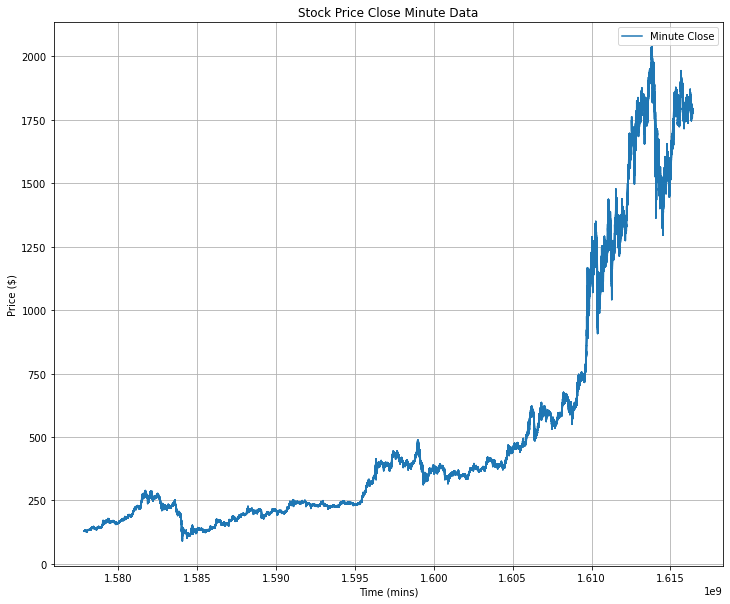

In [37]:
# Plots a dataframe using matplotlib
def mpl_plot(df):

    #Plot the file on a graph    
    df.plot(
        figsize = (12,10),
        title = 'Stock Price Close Minute Data',
        xlabel = 'Time (mins)',
        ylabel = 'Price ($)',
        y = 'c',
        x = 't',
        grid = True,
        label = 'Minute Close',
    )

    plt.show()

plot = mpl_plot(df)

Create Training, Testing, and Validation Dataframes

In [38]:
# The number of rows in the dataframe 
# Used for splitting the dataframe sizes
df_shape = df.shape[0]

# Split first 80% of dataframe into training set
# # Training set = 3541480
training_shape = int(df_shape * .8)
training_df = (df.iloc[:training_shape])

# Split next 10% of dataframe into testing set       
# Testing set = 44685           3541480:3984165
testing_shape = int(df_shape * .1)
testing_shape = (testing_shape + training_shape)
testing_df = df.iloc[training_shape:testing_shape]

# Split the last 10% of dataframe into validation set    
# Validation set = 44685
val_df= df.iloc[testing_shape:df_shape]

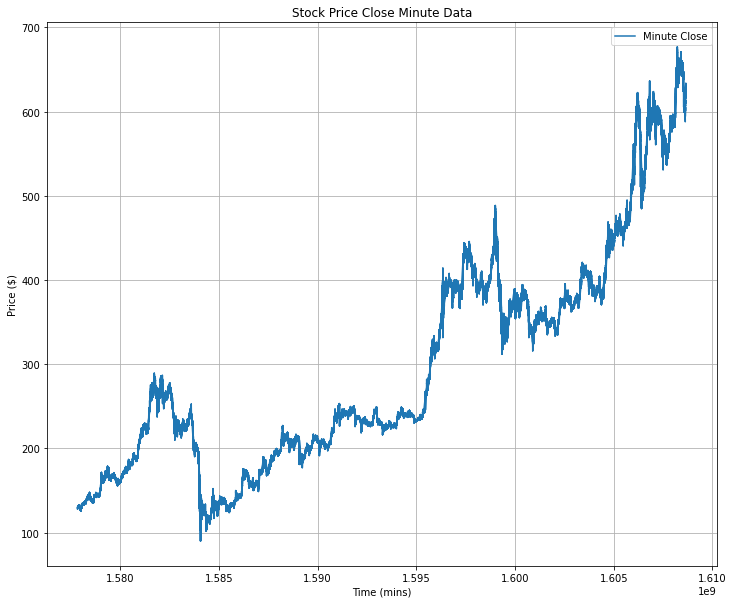

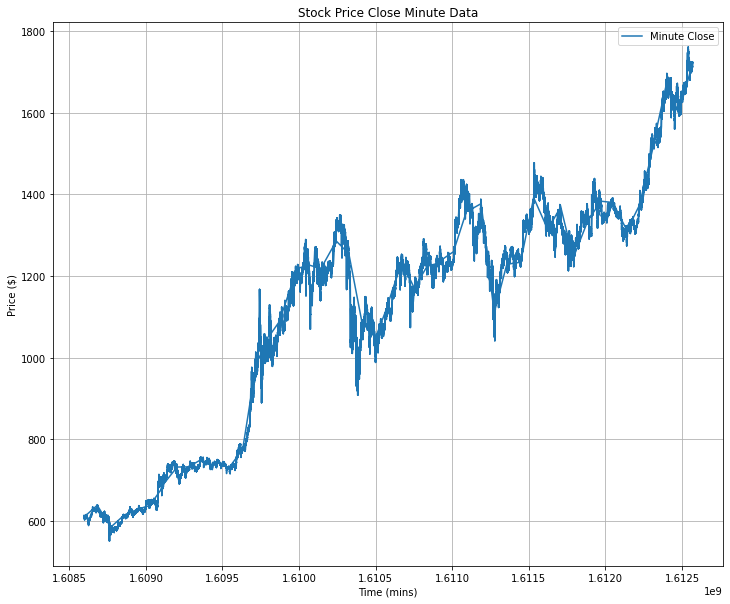

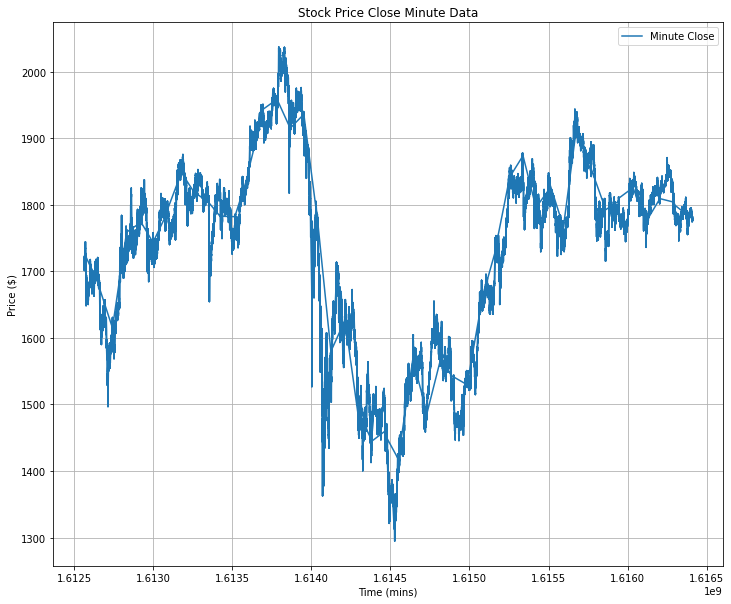

In [39]:
# Plot the training dataframe
plot_training = mpl_plot(training_df)

# Plot the testing dataframe
plot_testing = mpl_plot(testing_df)

# Plot the validation dataframe
plot_val = mpl_plot(val_df)

Create the Sequences for LSTM Model

In [42]:
from tqdm import tqdm


# This splits the dataframe into a list 
def create_sequences(df, target_column, sequence_length):
    sequences = []

    data_size = len(df)
  
    for i in tqdm(range(data_size - sequence_length)):

        sequence = df[i:i+sequence_length]

        label_position = i + sequence_length

        label = df.iloc[label_position][target_column]

        sequences.append((sequence, label))

    return sequences



In [52]:
SEQUENCE_LENGTH = 130


#These objects are lists
train_sequences = create_sequences(training_df, 'c', SEQUENCE_LENGTH)
test_sequences = create_sequences(testing_df, 'c', SEQUENCE_LENGTH)
val_sequences = create_sequences(val_df, 'c', SEQUENCE_LENGTH)



100%|██████████| 128031/128031 [00:22<00:00, 5787.42it/s]


In [83]:
#print(train_sequences[0:3])
print(train_sequences[0][0].shape)
print()

print(type(train_sequences))


print('Train Sequences length:')
print(len(train_sequences))
print('Testing Sequences length:')
print(len(test_sequences))
print('Validation Sequences length:')
print(len(val_sequences))

(130, 7)

<class 'list'>
Train Sequences length:
1025149
Testing Sequences length:
128029
Validation Sequences length:
128031


Pytorch Dataset

In [84]:
#Pytorch Dataset
class BTCDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence, label = self.sequences[index]
        return dict(
            sequence=torch.Tensor(sequence.to_numpy()),
            label = torch.tensor(label).float()
        )

In [85]:
#Price Data Module [Lightning]
class PriceDataModule(pl.LightningDataModule):
    def __init__(self, train_squences, test_squences, batch_size = 8):
        super().__init__()
        self.train_squences = train_squences
        self.test_squences = test_squences
        self.batch_size = batch_size

    def setup(self):
        self.train_dataset = BTCDataset(self.train_squences)
        self.test_dataset = BTCDataset(self.test_squences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size= self.batch_size,
            shuffle=False,
            num_workers=8,
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            shuffle=False,
            num_workers = 8
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            shuffle=False,
            num_workers = 8
        )

In [87]:
#Hyper parameters for model
num_epochs = 8
batch_size = 64

data_module = PriceDataModule(train_sequences, test_sequences, batch_size=batch_size)
data_module.setup()

In [88]:
train_dataset = BTCDataset(train_sequences)


In [89]:
for item in train_dataset:
    print(item["sequence"].shape)
    print(item["label"].shape)
    print(item["label"])
    break

torch.Size([130, 7])
torch.Size([])
tensor(130.0200)


Model

In [96]:
#price Prediction Model [Torch]
class PricePredictionModel(nn.Module):
    def __init__(self, n_features, n_hidden=128, n_layers=2):
        super().__init__()

        self.n_hidden = n_hidden

        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            batch_first = True,
            num_layers = n_layers,
            dropout = 0.2,

        )

        self.regressor = nn.Linear(n_hidden, 1)

    def forward(self, x):
        self.lstm.flatten_parameters()

        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]

        return self.regressor(out)

In [97]:
#Price Predictor [Lightning]
class PricePredictor(pl.LightningModule):
    def __init__(self, n_features: int):
        super().__init__()

        self.model = PricePredictionModel(n_features)
        self.criterion = nn.MSELoss()

    def forward(self, x, lables = None):
        output = self.model(x)
        loss = 0
        if lables is not None:
            loss = self.criterion(output, lables.unsqueeze(dim =1))

        return loss, output

    ###PICK UP FROM HERE
    def training_step(self, batch, batch_inx):
        sequences = batch["sequence"]
        lables = batch["label"]

        loss, outputs = self(sequences, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_inx):
        sequences = batch["sequence"]
        lables = batch["label"]

        loss, outputs = self(sequences, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_inx):
        sequences = batch["sequence"]
        lables = batch["label"]

        loss, outputs = self(sequences, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss        


    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=0.0001)

In [98]:
model = PricePredictionModel(n_features=training_df.shape[1])


In [99]:
for item in data_module.train_dataloader():
    print(item['sequence'].shape)
    print(item['lable'.shape])
    break

In [1]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

Launching TensorBoard...

KeyboardInterrupt: 

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints',
    filenames = 'best-checkpoint',
    save_top_k = 1,
    varbose = True,
    monitors = 'val_loss',
    mode = 'min'
)

logger = TensorboardLogger('lightning_logs', name = 'btc-price')

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

trainer = pl.Trainer(
    logger = logger,
    checkpoint_callback = checkpoint_callback,
    max_epochs = num_epochs,
    gpus = 1,
    progress_bar_refresh_rate = 30
)

In [ ]:
trainer.fit(model, data_module)

In [ ]:
trained_model = PricePredictor.load_from_checkpoint(
    
)